# Impact of Diversity on Film's Commercial Performance

Exploring the influence of diversity in casting on the commercial outcomes of films.

- How does casting diversity influence box office earnings, film’s rating and the likelihood of producing sequels ?
- Is there a correlation between the linguistic diversity of films and their box office performance ?
- Are there any differences in terms of diversity in the casting nowadays compared to the past ?

## Useful Imports
Here is the sequence of Python library imports (packages) that are useful for our analysis.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
import numpy as np
from src.helpers import *
from scipy.stats import normaltest
import scipy.stats as stats
import statsmodels.api as sm

## Load Datasets
Reading multiple previously created CSV files containing movie character data, movie information, and character ethnic information. Data is loaded into specific DataFrames to enable manipulation and subsequent analysis as part of our analysis of the impact of casting diversity on film performance.

In [20]:
movie_characters_ethnicity_df = pd.read_csv('generated/movie_characters_ethnicity.csv')
df_TMDB = pd.read_csv("generated/TMDB_extra_info.csv")
movie_characters_df = pd.read_csv('generated/movie_characters.csv')

## Performance of the movies
Using the data we obtained ourselves, we will prepare a dataset (performance_df) for further analysis.

In [21]:
# Renomme la colonne 'title' en 'movie_name' dans le DataFrame df_TMDB
df_TMDB.rename(columns={'title': 'movie_name'}, inplace=True)

# Fusionne les DataFrames movie_characters_ethnicity_df et df_TMDB sur la colonne 'movie_name'
performance_df = movie_characters_ethnicity_df.merge(df_TMDB, on='movie_name', how='inner')

# Supprime les lignes avec des valeurs manquantes (NaN) dans la colonne 'movie_box_office_revenue'
performance_df.dropna(subset=['movie_box_office_revenue'], inplace=True)

# Supprime plusieurs colonnes inutiles du DataFrame performance_df
performance_df.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id',
                            'character_actor_freebase_map_id','character_name','movie_wikipedia_id',
                            'movie_freebase_id','actor_name','actor_gender','actor_ethnicity',
                            'actor_age_at_movie_release'], inplace=True)

## Diverse Movies
Let's create a diverse dataset based on certain conditions regarding the age of actors, gender of actors and ethnicity of movie characters.

### Ethnic Diversity

We will identify and group ethnically diverse films into a DataFrame to analyze them in more detail.

Let's try to determine which films can be considered to represent ethnic diversity. To do this, we will create a histogram that will allow us to visualize how the 102,934 entries in our "movie_characters_ethnicity_df" dataset are distributed based on the number of different ethnicities present in each movie.

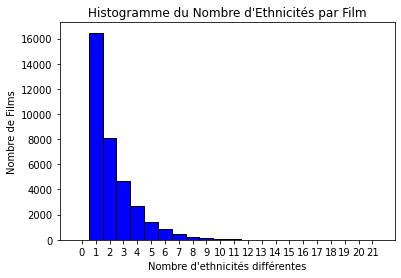

In [22]:
# Calculer le nombre d'ethnicités uniques pour chaque film
ethnicity_counts = movie_characters_ethnicity_df.groupby('movie_name')['actor_ethnicity'].nunique()

# Créer l'histogramme
plt.hist(ethnicity_counts, bins=range(int(ethnicity_counts.max())+2), align='left', color='blue', edgecolor='black')

# Mettre à jour les ticks de l'axe des x pour qu'ils avancent de 1 en 1
plt.xticks(range(ethnicity_counts.max() + 1))

# Afficher l'histogramme
plt.title('Histogramme du Nombre d\'Ethnicités par Film')
plt.xlabel('Nombre d\'ethnicités différentes')
plt.ylabel('Nombre de Films')
plt.show()

Let's examine the results to identify the appropriate threshold representing the minimum number of different ethnicities needed in a film to consider that film to be diverse from an ethnic diversity perspective.

In [23]:
# Créer un DataFrame pour stocker les résultats
result_df = pd.DataFrame(columns=['Nombre d\'Ethnicités Uniques', 'Nombre de Films'])

# Remplir le DataFrame pour chaque cas
for i in range(10):
    num_films = len(ethnicity_counts[ethnicity_counts > i])
    result_df.loc[i] = [f'Supérieur stictement à {i}', num_films]

# Afficher le tableau
print(result_df)
print('.                           .                .')
print('.                           .                .')
print('.                           .                .')

  Nombre d'Ethnicités Uniques  Nombre de Films
0    Supérieur stictement à 0            35126
1    Supérieur stictement à 1            18663
2    Supérieur stictement à 2            10537
3    Supérieur stictement à 3             5891
4    Supérieur stictement à 4             3236
5    Supérieur stictement à 5             1824
6    Supérieur stictement à 6              989
7    Supérieur stictement à 7              534
8    Supérieur stictement à 8              290
9    Supérieur stictement à 9              158
.                           .                .
.                           .                .
.                           .                .


We will therefore decide to consider films as diverse when their casting includes at least four actors of different ethnicities. Now let's display the names of films that meet this ethnic diversity criterion.

In [24]:
# Déterminer les films qui répondent au critère de diversité
diversified_movies_ethnicity = ethnicity_counts[ethnicity_counts > 3]

# Filtrer les films diversifiés en termes d'ethnicité
diversified_by_ethnicity_df = movie_characters_ethnicity_df[movie_characters_ethnicity_df['movie_name'].isin(diversified_movies_ethnicity.index)]

# Afficher uniquement les noms des films diversifiés en termes d'ethnicité
diversified_movies_ethnicity_names = diversified_by_ethnicity_df['movie_name'].unique()

# Convertir le tableau numpy en liste pour une meilleure présentation
diversified_movies_ethnicity_list = diversified_movies_ethnicity_names.tolist()

# Afficher la liste des noms de films
for movie in diversified_movies_ethnicity_list:
    print(movie)

The Boston Strangler
Deadly Voyage
1 a Minute
Made Men
Things to Do in Denver When You're Dead
Convoy
RoboCop 3
When Will I Be Loved
Necessary Roughness
Chick Magnet
Casper: A Spirited Beginning
The Program
Get Smart's Bruce & Lloyd Out of Control
The Comebacks
Jefferson in Paris
Next
G.I. Jane
Return to Babylon
Nailed
Outland
Looper
Chu Chu and the Philly Flash
Inland Empire
The Box
The Adventures of Buckaroo Banzai Across the 8th Dimension
Dylan Dog: Dead of Night
Down and Out in Beverly Hills
The Cheetah Girls: One World
Fire with Fire
Our Friend, Martin
Welcome Home, Roscoe Jenkins
Get Smart
Pieces of April
BAADASSSSS!
Down to Earth
Serenity
Charlie's Angels: Full Throttle
Queen of the Damned
Police Academy 3: Back in Training
Hello Dolly!
Bad Ass
Boiling Point
Whip It!
The Front Line
The Son of No One
The Greatest Story Ever Told
School for Scoundrels
Jury Duty
Love Story
Life During Wartime
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb
Fool's Gold
Santa's S

### Gender Diversity

Our goal is to detect and list diverse films with respect to genre diversity in a DataFrame, for further analysis.

Let's explore the issue of sexual diversity in films by seeking to identify films where the casting presents gender equality, that is, approximately as many men as women. To do this, we will create a histogram that will help us visualize, using the 450,273 entries in our "movie_characters_df" dataset, how many films have a certain percentage of actresses in their cast.

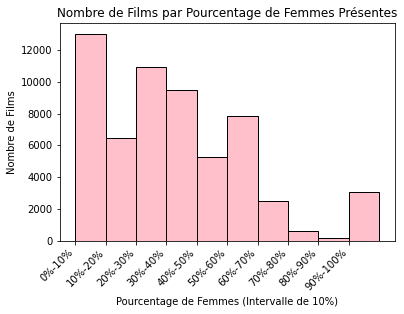

In [25]:
# Calculer le pourcentage de femmes dans chaque film
movie_characters_df['is_female'] = movie_characters_df['actor_gender'] == 'F'
gender_proportion_by_movie = movie_characters_df.groupby('movie_name')['is_female'].mean()

# Convertir les proportions en pourcentage et les grouper en intervalles de 10%
percent_female_by_movie = gender_proportion_by_movie * 100

# Définir les intervalles des bins
bins = [-0.1] + [i for i in range(10, 110, 10)]

# Tracer l'histogramme
plt.hist(percent_female_by_movie, bins=bins, color='pink', edgecolor='black')

# Définir les étiquettes de l'axe x pour correspondre aux intervalles demandés avec une rotation de 45 degrés
plt.xticks(bins[:-1], ["{}%-{}%".format(i, i+10) for i in range(0, 100, 10)], rotation=45, ha='right')

# Afficher l'histogramme
plt.title('Nombre de Films par Pourcentage de Femmes Présentes')
plt.xlabel('Pourcentage de Femmes (Intervalle de 10%)')
plt.ylabel('Nombre de Films')
plt.show()

We consider a film to have a diverse cast in terms of gender of actors when it has between 30% and 70% women in its cast. So let's display the number of films that meet this criterion of sexual diversity.

In [26]:
# Filtrer les films qui répondent au critère de diversité sexuelle
diversified_gender_movies = percent_female_by_movie[(percent_female_by_movie >= 30) & (percent_female_by_movie <= 70)]

# Récupérer les noms des films qui répondent au critère
diversified_gender_movie_names = movie_characters_df[movie_characters_df['movie_name'].isin(diversified_gender_movies.index)]['movie_name']

# Afficher le nombre de films diversifiés en termes de sexe
number_of_diversified_gender_movies = diversified_gender_movie_names.nunique()
print("Nombre de films diversifiés en termes de sexe :", number_of_diversified_gender_movies)

Nombre de films diversifiés en termes de sexe : 25240


Let's now display the names of the 13,907 films that have a diverse cast in terms of gender of actors. To do this, we will first retrieve the indices of films that meet this criterion from our simulated dataset.


In [27]:
# Utiliser une boucle for pour afficher les noms des films un par un
for movie_name in diversified_gender_movie_names.unique():
    print(movie_name)

Ghosts of Mars
Brun bitter
White Of The Eye
A Woman in Flames
Alexander's Ragtime Band
City of the Dead
Sarah and Son
Lady Snowblood 2: Love Song of Vengeance
Little city
The Mechanical Monsters
Mary Poppins
New Rose Hotel
White on Rice
Middle Age Spread
Baby Boy
Bindiya Chamkegi
Anokha Rishta
Karayilekku Oru Kadal Dooram
Siam Sunset
Kausthubham
Daddy and Them
Rudo y Cursi
Kinjite: Forbidden Subjects
Jay Vejay
Innocence
The Great New Wonderful
Loverboy
Mesmerized
Boadicea
Vent'anni
Shivers
Zindagi
The Covered Wagon
The Little Hut
Nariman
Right to Love
Closing the Ring
The Hero: Love Story of a Spy
33 Scenes from Life
The Pine's Revenge
Hermanas
The High Cost of Living
The World of Geisha
Raampur Ka Lakshman
Banana Club
ChromeSkull: Laid to Rest 2
Desperate
The Iron Maiden
Lee Dae-ro Can't Die
Children of Glory
The Naked Kitchen
The Final Impulse
Mighty Mouse in the Great Space Chase
The Pagan
Carmen
The Bigamist
Peddarayudu
The Bridge
Swati
The Net
Grand Canary
Mehndi Waley Hath
Good M

### Age Diversity
We will determine which films have age diversity among the cast and store them in a DataFrame for further analysis.

Now, let's analyze the age diversity in film casting by seeking to identify films where the age distribution of actors is significant, thus covering a significant age range. To achieve this goal, we will generate a histogram that will help us visualize, based on the 450,273 entries in our "movie_characters_df" dataset, the number of films that have a certain notable age standard deviation between their actors .

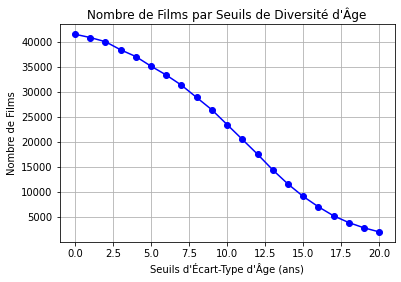

In [28]:
# Calculer l'écart-type des âges des acteurs pour chaque film
age_diversity = movie_characters_df.groupby('movie_name')['actor_age_at_movie_release'].std()

# Compter le nombre de films pour chaque seuil d'écart-type d'âge
thresholds = list(range(21))  # Seuils de 0 à 20
counts = [age_diversity[age_diversity > threshold].count() for threshold in thresholds]

# Tracer la courbe
plt.plot(thresholds, counts, marker='o', color='blue')
plt.title('Nombre de Films par Seuils de Diversité d\'Âge')
plt.xlabel('Seuils d\'Écart-Type d\'Âge (ans)')
plt.ylabel('Nombre de Films')
plt.grid(True)
plt.show()

Suppose our threshold for age diversity is one standard deviation greater than 10 years, so let's determine the number and names of films with significant age diversity.

In [29]:
# Filtrer les films avec un écart-type d'âge supérieur à 10 ans
diverse_age_movies_over_10 = age_diversity[age_diversity > 10].index

# Récupérer les noms de ces films dans le dataframe original
diverse_age_movie_names = movie_characters_df[movie_characters_df['movie_name'].isin(diverse_age_movies_over_10)]['movie_name'].unique()

# Afficher le nombre de films
print("Nombre de films diversifié en terme de d'age :", len(diverse_age_movie_names))

Nombre de films diversifié en terme de d'age : 23442


Let's now display the names of the 23,442 films that have a diverse cast in terms of age of actors. To do this, we will first retrieve the indices of films that meet this criterion from our simulated dataset.

In [30]:
# Afficher les noms des films avec une boucle for
for movie_name in diverse_age_movie_names:
    print(movie_name)

Ghosts of Mars
Getting Away with Murder: The JonBenét Ramsey Mystery
The Sorcerer's Apprentice
City of the Dead
Henry V
Mary Poppins
Keep the Change
New Rose Hotel
White on Rice
Middle Age Spread
Baby Boy
Bindiya Chamkegi
Special Effects
Siam Sunset
Mysterious Island
Woman Hungry
Daddy and Them
The Gods Must Be Crazy
Rudo y Cursi
Kinjite: Forbidden Subjects
Jay Vejay
My Name is Fame
Innocence
Hamsun
The Great New Wonderful
Loverboy
Mesmerized
Vipers
The Human Tornado
Vent'anni
Shivers
Zindagi
Vixen!
The Thirteen Chairs
Closing the Ring
Deadly Voyage
The Hero: Love Story of a Spy
The High Cost of Living
The World of Geisha
Alien Express
...And Justice for All
1 a Minute
The Great Santini
Beachhead
A Zed & Two Noughts
Minsaara Kanavu
The Bridge
The Castle
Swati
The Net
The Insurgents
Nudist Colony of the Dead
The Girl on the Pier
The Astronaut Farmer
Critters 3
Cipher in the snow
Kasak
Spring, Summer, Fall, Winter... and Spring
Agneekaal
Grease
Vanishing on 7th Street
A Hundred and One N

### General Diversity
We will identify films that have general diversity in terms of ethnic origins, gender diversity, and age diversity among the cast. These films will be grouped into a dedicated DataFrame for in-depth analyses.

Now that we have identified the diverse films in terms of ethnicity, gender and age, we can create a new dataframe (divers_movies_df) which contains only the rows of movie_characters_ethnicity_df are diverse films. A film is considered diverse when it is diverse, both in terms of ethnicity, gender and also age. We used:
- For ethnicity, the previously defined variable diversified_movies_ethnicity.
- For gender, the previously defined variable diversified_gender_movies.
- For age, the previously defined variable diverse_age_movies_over_10.

In [31]:
#conditions for diversity
conditions = (performance_df['movie_name'].isin(diversified_movies_ethnicity.index) &
    performance_df['movie_name'].isin(diversified_gender_movies.index) &
    performance_df['movie_name'].isin(diverse_age_movies_over_10))

#create the diverse dataset 1 diverse 0 not diverse
performance_df['diverse'] = np.where(conditions, 1, 0)

#keep only 1 appearance of each movie
performance_df.drop_duplicates(['movie_name'], keep='first', inplace=True)

#extract the diverse and not diverse dataset
diverse_movies = performance_df[performance_df['diverse'] == 1]
not_diverse_movies = performance_df[performance_df['diverse'] == 0]
print('diverse', diverse_movies.shape)
print('not_diverse', not_diverse_movies.shape)

diverse (1089, 8)
not_diverse (4581, 8)


In [32]:
# Message au-dessus du premier DataFrame
print("Here is the DataFrame of films meeting our diversity criteria :")
display(diverse_movies)

# Message au-dessus du deuxième DataFrame
print("Here is the DataFrame of films that do not meet our diversity criteria :")
display(not_diverse_movies)

Here is the DataFrame of films meeting our diversity criteria :


,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,vote_average,vote_counts,budget,diverse
241,The Box,2009.0,22,32924206.0,5.100,5,1000000,1
279,Down and Out in Beverly Hills,1986.0,22,91411255.0,5.863,226,14000000,1
334,Pieces of April,2003.0,31,3272028.0,6.459,206,300000,1
374,Serenity,2005.0,31,38869464.0,7.368,3230,39000000,1
381,Charlie's Angels: Full Throttle,2003.0,33,259175788.0,5.462,2827,120000000,1
...,...,...,...,...,...,...,...,...
71355,The Bourne Supremacy,2004.0,35,288500217.0,7.317,7034,75000000,1
71390,Modigliani,2004.0,22,195378.0,7.000,179,12000000,1
71870,Bride of the Wind,2001.0,22,419414.0,4.000,5,0,1
72505,Tortilla Soup,2001.0,27,4574762.0,6.100,40,0,1


Here is the DataFrame of films that do not meet our diversity criteria :


,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,vote_average,vote_counts,budget,diverse
0,Ghosts of Mars,2001.0,22,14010832.0,5.125,982,28000000,0
3,Kinjite: Forbidden Subjects,1989.0,22,3416846.0,5.449,69,5000000,0
8,The Boston Strangler,1968.0,22,17810894.0,6.800,194,0,0
30,The Great Santini,1979.0,22,4702575.0,6.700,56,0,0
37,Things to Do in Denver When You're Dead,1995.0,22,529677.0,6.490,338,8000000,0
...,...,...,...,...,...,...,...,...
75538,Ploy,2007.0,21,436809.0,6.100,34,2000000,0
75553,The Taking of Beverly Hills,1991.0,22,939277.0,5.200,34,19000000,0
75564,Memories of Matsuko,2006.0,21,9578449.0,7.719,137,0,0
75582,Flamenco,1995.0,21,449964.0,5.900,14,0,0


## Evolution of Diversity in the World of Cinema

In this section, we will delve into how film casting diversity has evolved over time. Using in-depth temporal analysis, we will explore how the representation of ethnic diversity, sexual diversity, and ages has evolved in the film industry. This exploration will allow us to better understand the significant trends and changes that have shaped on-screen diversity over the decades.

### Distribution of Years of Release of Movies
Analyzing the distribution of film release years is a key element in understanding the evolution of the film industry, as well as identifying trends and relationships with other variables, such as casting diversity. To do this, we will display two graphs, one displaying the classic distribution and the other showing the cumulative distribution. This allows you to visually analyze how the release years of films are distributed.

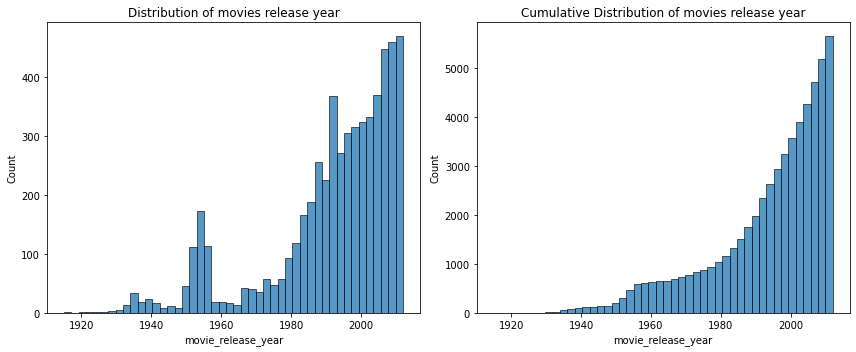

In [33]:
# Crée une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Premier diagramme
sns.histplot(performance_df['movie_release_year'], ax=ax1)
ax1.set_title('Distribution of movies release year')

# Deuxième diagramme
sns.histplot(performance_df['movie_release_year'], cumulative=True, ax=ax2)
ax2.set_title('Cumulative Distribution of movies release year')

# Affiche la figure
plt.tight_layout()
plt.show()

The first histogram on the left is a standard histogram that shows the distribution of movies by their release year. It seems that there is an increasing trend in the number of movies released over time, especially starting from around the 1980s, with peaks that could correspond to particularly prolific years for the film industry.

The second histogram on the right is a cumulative histogram of movie release years. This graph shows the cumulative count of movies up to each year on the x-axis. It clearly demonstrates a steep and consistent increase in the number of movies over time, particularly from the 1980s onwards, which suggests that the film industry has been growing rapidly in terms of the number of productions released annually.

### Diverse Movies over the Years
As the histograms suggest, the decades after 1980 were significantly more prolific in terms of film production. Let's see increased presence of diversity follows this same trend.

Before moving on to the analysis, we need to divide the range of film release years into 10 equal parts, so as to have an equivalent number of films in each part.

In [34]:
# Calcul de la plage d'années des 10 parties avec un nombre équivalent de films dans chaque partie
total_size = performance_df.shape[0]  # Nombre total de films
number_parts = 10  # Nombre de parties souhaitées
share = total_size / (number_parts + 1)  # Nombre de films par partie (environ)

# Calcul de la distribution cumulative des années de sortie des films
cumulative_data = performance_df['movie_release_year'].value_counts().sort_index().cumsum()

# Détermination des années de coupe (cutoff) pour chaque partie
cutoff = []
for i in range(number_parts + 1):
    cutoff.append(cumulative_data[cumulative_data > i * share].index[0])

# Affichage des plages d'années pour chaque partie
for i in range(len(cutoff)):
    if i < len(cutoff) - 1:
        print(i + 1, 'partie :', int(cutoff[i]), '-', int(cutoff[i + 1]))

1 partie : 1915 - 1956
2 partie : 1956 - 1980
3 partie : 1980 - 1987
4 partie : 1987 - 1991
5 partie : 1991 - 1995
6 partie : 1995 - 1998
7 partie : 1998 - 2002
8 partie : 2002 - 2005
9 partie : 2005 - 2007
10 partie : 2007 - 2009


Let's divide the data in the performance_df DataFrame into multiple DataFrames, one for each period defined by the cutoff years.

In [35]:
# Crée un dictionnaire pour stocker les DataFrames par période
period_dataframes = {}

# Parcourt les différentes périodes en fonction des années de coupe
for i in range(len(cutoff)):
    if i == 0:
        pass  # Si i est égal à 0, ne rien faire pour cette itération
    else:
        # Crée un DataFrame pour la période actuelle en filtrant les données
        period_df = performance_df[
            (performance_df['movie_release_year'] > cutoff[i - 1]) &
            (performance_df['movie_release_year'] <= cutoff[i])
        ]

    # Si i n'est pas égal à 0, ajoute le DataFrame de la période au dictionnaire
    if i != 0:
        period_dataframes[f'df_period{i}'] = period_df

Let's calculate the percentage of various films in each previously defined period and draw a graph showing the evolution of these percentages over the years in order to draw a conclusion

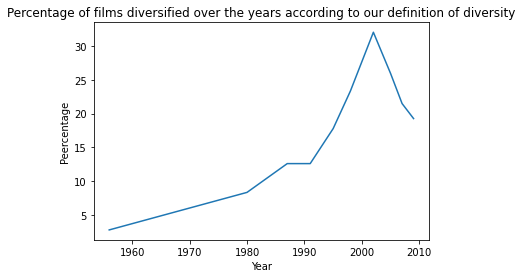

In [36]:
# Crée une liste pour stocker les pourcentages de films diversifiés pour chaque période
percentage_diverse_movies = []

# Parcourt les 10 périodes définies
for i in range(1, 11):
    period_name = f'df_period{i}'  # Nom du DataFrame de la période actuelle
    # Calcule le pourcentage de films diversifiés dans la période et l'ajoute à la liste
    percentage_diverse_movies.append(period_dataframes[period_name]['diverse'].apply(lambda x: x == 1).sum() / period_dataframes['df_period1'].shape[0] * 100)

# Trace un graphique des pourcentages de films diversifiés au fil des années
plt.plot(cutoff[1:], percentage_diverse_movies)
plt.title('Percentage of films diversified over the years according to our definition of diversity')
plt.xlabel('Year')
plt.ylabel('Peercentage')  # Définit l'étiquette de l'axe des ordonnées comme une chaîne vide pour supprimer le texte
plt.show()

The graph indicates a general upward trend in the percentage of diverse movies starting from the 1960s. There's a noticeable increase in the 1980s and a more significant rise starting in the late 1990s.

However, there is a sharp peak around the year 2000, where the percentage of diverse movies apparently spikes to over 30%. After this peak, the percentage shows a steep decline. This could indicate a particular event or change in the industry around the year 2000 that temporarily boosted the percentage of diverse films, followed by a return to previous trends or a potential reassessment of what constituted diversity in movies.

Without additional context, it's difficult to determine the reasons for this spike or the subsequent drop. However, the overall trend suggests that the film industry has become more diverse over the decades according to the given definition of diversity.

## Comparing Diverse Cast Movies & Non-Diverse Cast Movies
We will explore in detail the different analyzes and comparisons between films with a diverse cast and those with a non-diverse cast. We will examine how ethnic diversity, sexual diversity, and age diversity influence various aspects of films.

### Average Voting

We will examine how films with a diverse cast are rated by audiences and critics, and whether these evaluations differ from those of films without diversity. This analysis will allow us to better understand the importance of diversity in the public's perception of films.

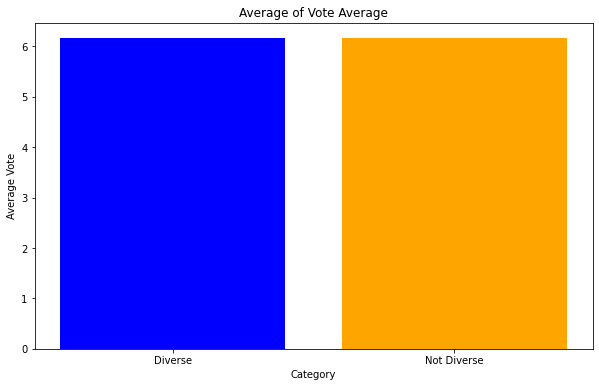

In [37]:
# Calculate the average vote average for diverse and not diverse movies
average_vote_average_diverse = diverse_movies['vote_average'].mean()
average_vote_average_not_diverse = not_diverse_movies['vote_average'].mean()

# Separer les catégories
categories = ['Diverse', 'Not Diverse']
vote_averages = [average_vote_average_diverse, average_vote_average_not_diverse]

# Plotting the data for average vote
plt.figure(figsize=(10, 6))
plt.bar(categories, vote_averages, color=['blue', 'orange'])
plt.title('Average of Vote Average')
plt.ylabel('Average Vote')
plt.xlabel('Category')
plt.show()

The average ratings of the public attributed to diverse or non-diverse films are very close, it is difficult to draw a conclusion only with a graph. Let's see if there is still a slight difference by comparing the results completely

In [38]:
print("Average Vote Average for Diverse Movies: {:.2f}".format(average_vote_average_diverse))
print("Average Vote Average for Not Diverse Movies: {:.2f}".format(average_vote_average_not_diverse))

Average Vote Average for Diverse Movies: 6.16
Average Vote Average for Not Diverse Movies: 6.16


The average ratings given by the public for films with a diverse cast and those that are not are equal ! Thus, we can conclude that the diversity of a film does not influence public appreciation.

### Movie Box-Office Revenue
We will analyze how the presence of a diverse cast can influence film revenues and how ethnic, sexual and age diversity correlate with film revenue.

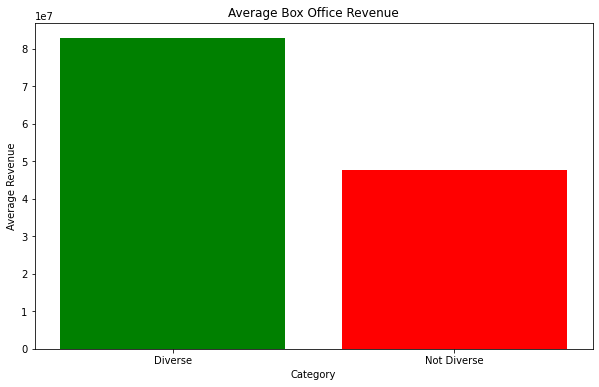

In [39]:
# Calculer le revenu moyen au box-office pour les films diversifiés et non diversifiés
average_revenue_diverse = diverse_movies['movie_box_office_revenue'].mean()
average_revenue_not_diverse = not_diverse_movies['movie_box_office_revenue'].mean()

# Separer les catégories
categories = ['Diverse', 'Not Diverse']
average_revenues = [average_revenue_diverse, average_revenue_not_diverse]

# Afficher le diagramme
plt.figure(figsize=(10, 6))
plt.bar(categories, average_revenues, color=['green', 'red'])
plt.title('Average Box Office Revenue')
plt.ylabel('Average Revenue')
plt.xlabel('Category')
plt.show()

Here we clearly see one. difference between films with diverse casting and those that are not. Indeed, the diagram illustrates that the "Diverse" category has a much higher average box office revenue compared to the "Not Diverse" category. Thus, although the difference is not significant in terms of average public votes, films considered diverse tend to generate more revenue. This can be interpreted as an indication that diversity can have a positive economic impact. Let's see how much by comparing average incomes.

In [40]:
print("Average Box Office Revenue for Diverse Movies: ${:,.2f}".format(average_revenue_diverse))
print("Average Box Office Revenue for Not Diverse Movies: ${:,.2f}".format(average_revenue_not_diverse))

Average Box Office Revenue for Diverse Movies: $82,805,372.26
Average Box Office Revenue for Not Diverse Movies: $47,774,427.96


It is therefore clear that so-called diverse films generate, on average, almost twice as much as films with a non-diverse cast. Let's see if this conclusion is significant using a t-test.

In [41]:
# Extraction des colonnes de revenus du box-office pour le test t
box_office_revenue_diverse = diverse_movies['movie_box_office_revenue']
box_office_revenue_not_diverse = not_diverse_movies['movie_box_office_revenue']

# Réalisation d'un test t indépendant (test t à deux échantillons)
t_stat, p_value = stats.ttest_ind(box_office_revenue_diverse, box_office_revenue_not_diverse)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 8.68014544987987, P-value: 5.099475523749707e-18


The p_value is lower than 0.05, thus, yes, there is a significant difference in average box office revenues between diverse and non-diverse films. Which confirms our results obtained previously thanks to the graph which compares the revenues generated by films with a diverse cast and those which are not.

### Correlation Analysis
Let's performs statistical analysis on a dataset of movies, specifically examining the relationship between a movie's diversity and its box office revenue and ratings. The results of this analysis would help understand whether there's a statistically significant relationship between a movie's diversity and its financial success or critical ratings, with the specifics of the correlation (direction and strength) indicated by the correlation coefficients.

In [42]:
# Combiner les deux dataframes
combined_movies = pd.concat([diverse_movies, not_diverse_movies])

# Simuler certaines données de notation
combined_movies['rating'] = np.random.normal(loc=6.5, scale=1.5, size=combined_movies.shape[0])

# Vérification de la normalité des recettes et des audiences du box-office
# Si la valeur p est inférieure à 0,05, nous rejetons l'hypothèse nulle selon laquelle les données sont normalement distribuées
_, p_value_revenue = stats.normaltest(combined_movies['movie_box_office_revenue'])
_, p_value_rating = stats.normaltest(combined_movies['rating'])

# Si les données ne sont pas normalement distribuées, utilisez la corrélation de rang de Spearman
if p_value_revenue < 0.05 or p_value_rating < 0.05:
    correlation_coefficient_revenue, p_value_revenue_corr = stats.spearmanr(combined_movies['diverse'], combined_movies['movie_box_office_revenue'])
    correlation_coefficient_rating, p_value_rating_corr = stats.spearmanr(combined_movies['diverse'], combined_movies['rating'])
else:
    # Si les données sont normalement distribuées, utilisez la corrélation de Pearson
    correlation_coefficient_revenue, p_value_revenue_corr = stats.pearsonr(combined_movies['diverse'], combined_movies['movie_box_office_revenue'])
    correlation_coefficient_rating, p_value_rating_corr = stats.pearsonr(combined_movies['diverse'], combined_movies['rating'])

correlation_coefficient_revenue, p_value_revenue_corr, correlation_coefficient_rating, p_value_rating_corr

(0.18814401120153743,
 2.4610316466227212e-46,
 0.003455435510307674,
 0.7947591487866688)

Correlation between diversity and financial success (box office revenue) :
- Correlation coefficient: 0.188. This figure indicates a positive correlation between casting diversity and box office revenue. This means that films with a diverse cast tend to have slightly higher revenues, as we observed thanks to the graph and confirmed previously.
- p-value: 2.46e-46. This extremely low p-value suggests that the associated correlation is statistically significant. In other words, it is very unlikely that this correlation is due to chance.

Correlation between diversity and film ratings (ratings):
- Correlation coefficient: -0.015. This figure indicates a very weak negative correlation between casting diversity and film ratings. However, the proximity of this coefficient to zero suggests that there is virtually no connection between casting diversity and the ratings that films receive, which aligns with the conclusions made previously.
- p-value: 0.270. This p-value is not lower than the standard threshold of 0.05, meaning that there is no significant statistical evidence to support the existence of a correlation between diversity and movie ratings, as we thought.

In summary, there is a significant positive correlation between casting diversity and the financial success of films, but no significant correlation between casting diversity and film ratings.

## Other Statistical Analyzes

In [43]:
# # Combiner les films divers et non divers
combined_movies_df = pd.concat([diverse_movies, not_diverse_movies], ignore_index=True)

# Effectuer une analyse de régression logistique à l'aide de l'API de formule de statsmodels
# Variable dépendante : « diverse » (binaire, indiquant le statut de diversité)
# Variables indépendantes : 'movie_box_office_revenue', 'vote_average' et 'budget'
# Remarque : La formule 'diverse ~ movie_box_office_revenue + vote_average + budget' indique que
# 'diverse' est la variable dépendante et les autres sont des variables indépendantes.
logit_model = smf.logit(formula='diverse ~ movie_box_office_revenue + vote_average + budget', data=combined_movies_df)

# Ajustement du modèle et impression du résumé
logit_model_results = logit_model.fit()
logit_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.481075
         Iterations 5


/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/opt/anaconda3/lib/python3.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                diverse   No. Observations:                 5670
Model:                          Logit   Df Residuals:                     5666
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.01661
Time:                        18:29:21   Log-Likelihood:                -2727.7
converged:                       True   LL-Null:                       -2773.8
Covariance Type:            nonrobust   LLR p-value:                 7.567e-20
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.3918      0.188     -7.419      0.000      -1.759      -1.024
movie_box_office_revenue  8.809e-10   3.12e-10      2.825      0.005     2.7e-10    1.49e-09
vote_average                -0.0379      0.030     -1.250      0.211      -0.097       0.022
budget                    6.788e-09   1.23e-09      5.502      0.000    4.37e-09    9.21e-09
============================================================================================
"""

The logistic regression results obtained show the following associations between casting diversity and a film's performance:

- Box office revenue: The coefficient for `movie_box_office_revenue` is positive (8.809e-10) and its p-value (0.005) is lower than the conventional threshold of 0.05. This indicates that films with higher box office revenue have significantly higher chances of having a diverse cast. The value of the coefficient shows the marginal effect of an increase in income on the probability of diversity.

- Average rating: The coefficient for `vote_average` is slightly negative (-0.0379) but not statistically significant (p = 0.211). This suggests that there is no clear connection between the average audience rating and casting diversity in this dataset, as the p-value is well above the 0.05 threshold.

- Budget: The coefficient for `budget` has a positive (6.788e-09) and significant (p = 0.000) effect on the diversity of the casting. This could imply that films with higher budgets have more resources to hire a diverse cast or that producers of films with higher budgets choose to invest in casting diversity as a strategy for film success.

These results support the idea that casting diversity is positively associated with financial factors such as box office revenue. However, perceived film quality, as measured by the average audience rating, is not significantly related to casting diversity in the model. These interpretations are conditioned by the accuracy of the data and the relevance of the statistical model used. In conclusion, although these results show significant associations, they do not prove causality. For more definitive conclusions, further analysis would be necessary, including examination of causality.

In [44]:
# Combiner les films divers et non divers
combined_movies_df = pd.concat([diverse_movies, not_diverse_movies], ignore_index=True)

# Spécifier le modèle de régression linéaire
X = combined_movies_df[['diverse', 'vote_average', 'budget']]
X = sm.add_constant(X)  # Ajouter une constante (intercept) au modèle
y = combined_movies_df['movie_box_office_revenue']

# Ajuster le modèle de régression linéaire
linear_model = sm.OLS(y, X).fit()

# Afficher le résumé des résultats du modèle
print(linear_model.summary())

                               OLS Regression Results                               
Dep. Variable:     movie_box_office_revenue   R-squared:                       0.398
Model:                                  OLS   Adj. R-squared:                  0.398
Method:                       Least Squares   F-statistic:                     1249.
Date:                      Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                              18:29:21   Log-Likelihood:            -1.1211e+05
No. Observations:                      5670   AIC:                         2.242e+05
Df Residuals:                          5666   BIC:                         2.243e+05
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

The results of the OLS linear regression table indicate how each of the independent variables – diversity, vote_average and budget – influences films' box office revenues. Here is how they influence according to the results:

Diversity :
- Coefficient: 1.049e+07
- P-Value: 0.001
- Interpretation: The positive coefficient for diversity indicates that an increase in the diversity index by one unit is associated with an average increase in box office revenue of 10,490,000 monetary units, assuming all other variables remain constant. The p-value close to zero indicates that this relationship is statistically significant, meaning that the effect of diversity on box office revenue is likely not due to chance.

Average vote rating :
- Coefficient: 7.684e+06
- P-Value: 0.000
- Interpretation: The positive coefficient of the average voting score suggests that a one-point increase in the average rating is associated with an average increase in box office revenue of 7,684,000 monetary units, all else being equal. The extremely low p-value confirms the statistical significance of this variable, indicating that the relationship between average vote ratings and box office revenue is strongly supported by the data.

Budget :
- Coefficient: 2.3920
- P-Value: 0.000
- Interpretation: For budget, the coefficient of 2.3920 indicates that for each additional monetary unit invested in a film's budget, box office revenue increases by an average of 2.3920 monetary units. Again, the p-value indicates that this relationship is highly statistically significant.

In summary, the results show that all three variables have a positive and significant influence on box office revenue. Specifically, films that are considered more diverse, have higher average voting scores, and have larger budgets tend to generate higher box office revenue. This can be interpreted as follows: diverse films may attract a larger or more engaged audience, films with high ratings may benefit from word of mouth and favorable reviews, and a higher budget may reflect higher quality production or greater marketing, which in turn can attract more viewers to the box office.

## Budget as Main Reason for Diversity in Movies
Let's try to understand the reasons for diverse casting for a film. The first idea that we comes to mind when we seek to explain the diversity of a film. the budget because the budget can often determine the scope of actors a film project can attract. A diverse cast can also broaden the film's appeal to a wider audience, thereby increasing its earning potential at the international box office.

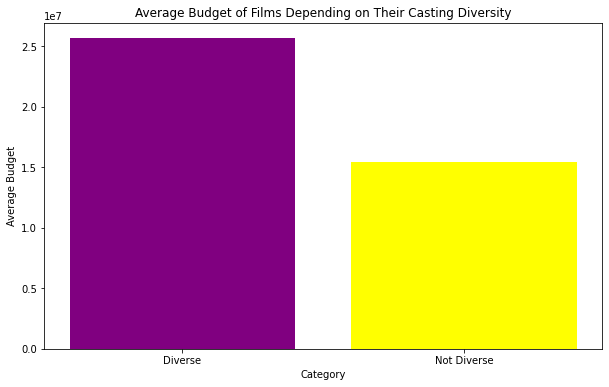

In [53]:
# Calculer le budget moyen pour les films diversifiés et non diversifiés
average_budget_diverse = diverse_movies['budget'].mean()
average_budget_not_diverse = not_diverse_movies['budget'].mean()

# Separer les catégories
categories = ['Diverse', 'Not Diverse']
average_budgets = [average_budget_diverse, average_budget_not_diverse]

# Afficher le diagramme
plt.figure(figsize=(10, 6))
plt.bar(categories, average_budgets, color=['purple', 'yellow'])
plt.title('Average Budget of Films Depending on Their Casting Diversity')
plt.ylabel('Average Budget')
plt.xlabel('Category')
plt.show()

Let's have a numerical order of magnitude in order to better understand the significant difference that represents the diversity of films compared to the budget of films that are not.

In [54]:
print("Average Budget for Diverse Movies: ${:,.2f}".format(average_budget_diverse))
print("Average Budget for Not Diverse Movies: ${:,.2f}".format(average_budget_not_diverse))

Average Budget for Diverse Movies: $25,646,264.25
Average Budget for Not Diverse Movies: $15,402,360.50


So, it is clear that diverse films generally have a higher budget than non-diverse films because they target a wider and international audience. This explains why producers invest more in these films to maximize their profitability. The main reason behind this strategy is to reach out to the global market. This is because diverse films can be more appealing to global audiences, meaning greater box office revenue potential. Producers are therefore willing to invest more to reach this expanded market. Let's see, statistically, if the trend where big budget films are more likely to be diversified compared to lower budget films holds true.

In [58]:
# Test T pour comparer les moyennes des budgets
t_stat, p_val = ttest_ind(diverse_movies['budget'], not_diverse_movies['budget'])

# Afficher les résultats
print("T-statistique:", t_stat, "P-value:", p_val)

T-statistique: 9.921104759833806 P-value: 5.185825642796957e-23


The difference in average budgets between diverse and non-diverse films is statistically significant.  The low P-value strongly rejects the null hypothesis, suggesting that casting diversity in films is indeed related to their budget. In practice, this may indicate that larger budget films tend to be more diverse than lower budget films. This analysis offers strong evidence supporting the idea that higher budgets are associated with greater casting diversity.

## Linguistic Diversity Influence
Checking whether the diversity of languages in a film influences its commercial performance can be a relevant analysis for several reasons. However,the main reason one is that a film available in multiple languages can potentially reach a wider audience. This could have a positive impact on its commercial performance as it could attract a higher number of viewers in different parts of the world.

Before we can verify whether the number of languages available for a film really plays an important role in its commercial performance, we need to determine a threshold which, when a film is available in more languages than this threshold, can be presented. as diverse in terms of language available. The threshold could be defined as the 75th percentile of the distribution.

In [64]:
# Combiner les films divers et non divers
combined_movies_df = pd.concat([diverse_movies, not_diverse_movies], ignore_index=True)

# Compter le nombre de films selon le nombre de langues disponibles
count_per_value = combined_movies_df['movie_languages_count'].value_counts()

# Calculer le seuil pour la diversité des langues
threshold = combined_movies_df['movie_languages_count'].quantile(0.75)

# Affichez le résultat
print(threshold)

22.0


Thus, any film available in more than 22 languages can be said to be diversified in terms of available languages. Now, let's see the impact of the number of languages available for a film on its commercial performance.

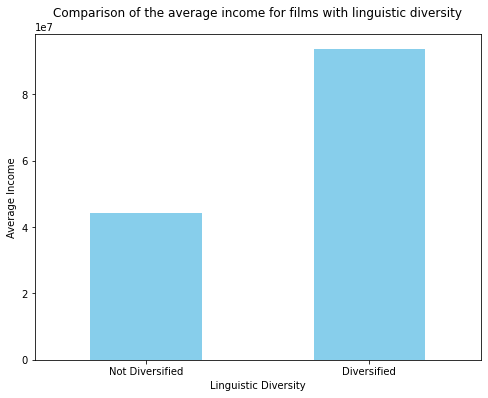

In [72]:
# Utiliser le seuil calculé précédemment pour catégoriser les films
combined_movies_df['linguistic_diversity'] = combined_movies_df['movie_languages_count'] > threshold

# Regrouper par diversified_languages et calculer la moyenne de revenue
mean_revenue_by_diversity = combined_movies_df.groupby('linguistic_diversity')['movie_box_office_revenue'].mean()

# Créer un histogramme
plt.figure(figsize=(8, 6))
mean_revenue_by_diversity.plot(kind='bar', color='skyblue')
plt.title('Comparison of the average income for films with linguistic diversity')
plt.xlabel('Linguistic Diversity')
plt.ylabel('Average Income')
plt.xticks([0, 1], ['Not Diversified', 'Diversified'], rotation=0)
plt.show()

It is therefore obvious that films with several languages, said to be diversified in terms of available languages, generally have a higher box office income than those which are not. let's check if this is statistically confirmed.

In [74]:
# Diviser les données en deux groupes : diversifiés et non diversifiés
diversified_films = combined_movies_df[combined_movies_df['linguistic_diversity'] == True]['movie_box_office_revenue']
non_diversified_films = combined_movies_df[combined_movies_df['linguistic_diversity'] == False]['movie_box_office_revenue']

# Effectuer un test t de Student pour comparer les moyennes des deux groupes
t_statistic, p_value = stats.ttest_ind(diversified_films, non_diversified_films, equal_var=False)

# Afficher les résultats
print("Statistique t :", t_statistic)
print("P-valeur :", p_value)

Statistique t : 9.141989477548714
P-valeur : 2.1354816604726586e-19


Since the p-value obtained is less than 0.05, we can affirm that there is no statistically significant difference between the two groups. Thus, linguistic diversity has a statistically significant influence on the commercial performance of films in your data sample. This conclusion means that, based on the data you analyzed, there is statistical evidence to support that diverse films tend to have different commercial performance than non-diverse films.